# MARL with Two Agents - Step-by-Step Implementation

This notebook demonstrates a complete implementation of Multi-Agent Reinforcement Learning with two agents using Independent Q-Learning (IQL) in the `simple_tag_v3` environment.


In [ ]:
# %%
!pip install pettingzoo==1.24.1 numpy matplotlihttps://file+.vscode-resource.vscode-cdn.net/home/hope/Project_package/marl_two_agents/.venv/lib/python3.12/site-packagesb pygame pyyaml gymnasium

In [2]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.mpe import simple_tag_v3
from collections import defaultdict

# Initialize the environment
env = simple_tag_v3.env(
    num_adversaries=1,
    num_good=1,
    max_cycles=500,
    continuous_actions=False,
    render_mode="human"
)

# Reset the environment to get agent names
env.reset()
agent_names = env.agents.copy()

print("Agent names:", agent_names)
for agent in agent_names:
    print(f"\n{agent}:")
    print("Action space:", env.action_space(agent))
    print("Observation space:", env.observation_space(agent))

Agent names: ['adversary_0', 'agent_0']

adversary_0:
Action space: Discrete(5)
Observation space: Box(-inf, inf, (12,), float32)

agent_0:
Action space: Discrete(5)
Observation space: Box(-inf, inf, (10,), float32)


In [3]:
# %%
class IQLAgent:
    def __init__(self, agent_name, action_space, observation_space,
                 learning_rate=0.1, discount_factor=0.95,
                 exploration_rate=1.0, exploration_decay=0.995,
                 min_exploration=0.01):
        self.agent_name = agent_name
        self.action_space = action_space
        self.observation_space = observation_space
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))
        
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        
        self.last_action = None
        self.last_state = None
    
    def act(self, observation, training=True):
        """Choose action based on current observation"""
        if observation is None:  # Dead agent
            return None
            
        state = self._process_observation(observation)
        
        # Exploration
        if training and np.random.random() < self.exploration_rate:
            action = self.action_space.sample()
        # Exploitation
        else:
            action = np.argmax(self.q_table[state])
            
        self.last_state = state
        self.last_action = action
        return action
    
    def learn(self, next_observation, reward, done):
        """Update Q-table based on experience"""
        if self.last_state is None or self.last_action is None:
            return
            
        next_state = self._process_observation(next_observation) if next_observation is not None else None
        
        # Q-learning update
        current_q = self.q_table[self.last_state][self.last_action]
        max_next_q = np.max(self.q_table[next_state]) if (next_state is not None and not done) else 0
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )
        self.q_table[self.last_state][self.last_action] = new_q
        
        # Decay exploration
        if done:
            self.exploration_rate = max(
                self.min_exploration,
                self.exploration_rate * self.exploration_decay
            )
    
    def _process_observation(self, observation):
        """Discretize continuous observation for Q-table"""
        # Handle dict observations (newer PettingZoo versions)
        if isinstance(observation, dict):
            observation = observation['observation']
        # Ensure we have a numpy array
        observation = np.array(observation)
        return tuple((observation * 10).astype(int))  # Simple discretization

In [4]:
# %%
def train_marl(env, num_episodes=1000, render_every=100, log_every=50):
    """Train agents using Independent Q-Learning"""
    # Get agent names
    agent_names = env.agents
    
    # Initialize agents
    agents = {
        agent: IQLAgent(
            agent_name=agent,
            action_space=env.action_space(agent),
            observation_space=env.observation_space(agent),
            learning_rate=0.15 if "adversary" in agent else 0.1,
            discount_factor=0.9 if "adversary" in agent else 0.95
        )
        for agent in agent_names
    }
    
    # Tracking metrics
    episode_rewards = {agent: [] for agent in agent_names}
    episode_lengths = []
    exploration_rates = []
    
    for episode in range(num_episodes):
        env.reset()
        rewards_this_episode = {agent: 0 for agent in agent_names}
        done = False
        steps = 0
        
        for agent in env.agent_iter():
            observation, reward, termination, truncation, _ = env.last()
            done = termination or truncation
            
            # Get action from agent (None if agent is dead)
            action = agents[agent].act(observation) if not done else None
            
            # Step the environment
            env.step(action)
            
            # Get next observation for learning
            next_observation, next_reward, next_done, _, _ = env.last()
            next_done = next_done or truncation
            
            # Learn from experience (only if agent was alive when it acted)
            if not done:
                agents[agent].learn(
                    next_observation,
                    reward,
                    next_done
                )
                rewards_this_episode[agent] += reward
            
            steps += 1
            
            # Render occasionally
            if episode % render_every == 0:
                env.render()
            
            if all(env.terminations.values()) or all(env.truncations.values()):
                break
        
        # Store episode metrics
        for agent in agent_names:
            episode_rewards[agent].append(rewards_this_episode[agent])
        episode_lengths.append(steps)
        exploration_rates.append(np.mean([a.exploration_rate for a in agents.values()]))
        
        # Log progress
        if episode % log_every == 0:
            avg_rewards = {agent: np.mean(episode_rewards[agent][-log_every:]) for agent in agent_names}
            print(f"Episode {episode}:")
            print(f"  Avg rewards: {avg_rewards}")
            print(f"  Exploration: {exploration_rates[-1]:.2f}")
            print(f"  Steps: {steps}")
    
    return agents, episode_rewards, episode_lengths, exploration_rates

# Run training
print("Starting training...")
trained_agents, rewards, lengths, exploration = train_marl(env, num_episodes=500)
print("Training completed!")

Starting training...
Episode 0:
  Avg rewards: {'adversary_0': np.float64(0.0), 'agent_0': np.float64(-4791.483882431617)}
  Exploration: 1.00
  Steps: 1000
Episode 50:
  Avg rewards: {'adversary_0': np.float64(4.6), 'agent_0': np.float64(-3159.131839295963)}
  Exploration: 1.00
  Steps: 1000
Episode 100:
  Avg rewards: {'adversary_0': np.float64(14.0), 'agent_0': np.float64(-3016.4104907862475)}
  Exploration: 1.00
  Steps: 1000
Episode 150:
  Avg rewards: {'adversary_0': np.float64(7.8), 'agent_0': np.float64(-3135.9486335913352)}
  Exploration: 1.00
  Steps: 1000
Episode 200:
  Avg rewards: {'adversary_0': np.float64(7.2), 'agent_0': np.float64(-3222.0504936368147)}
  Exploration: 1.00
  Steps: 1000
Episode 250:
  Avg rewards: {'adversary_0': np.float64(4.8), 'agent_0': np.float64(-2883.387304583517)}
  Exploration: 1.00
  Steps: 1000
Episode 300:
  Avg rewards: {'adversary_0': np.float64(11.4), 'agent_0': np.float64(-2859.484794571546)}
  Exploration: 1.00
  Steps: 1000
Episode 350

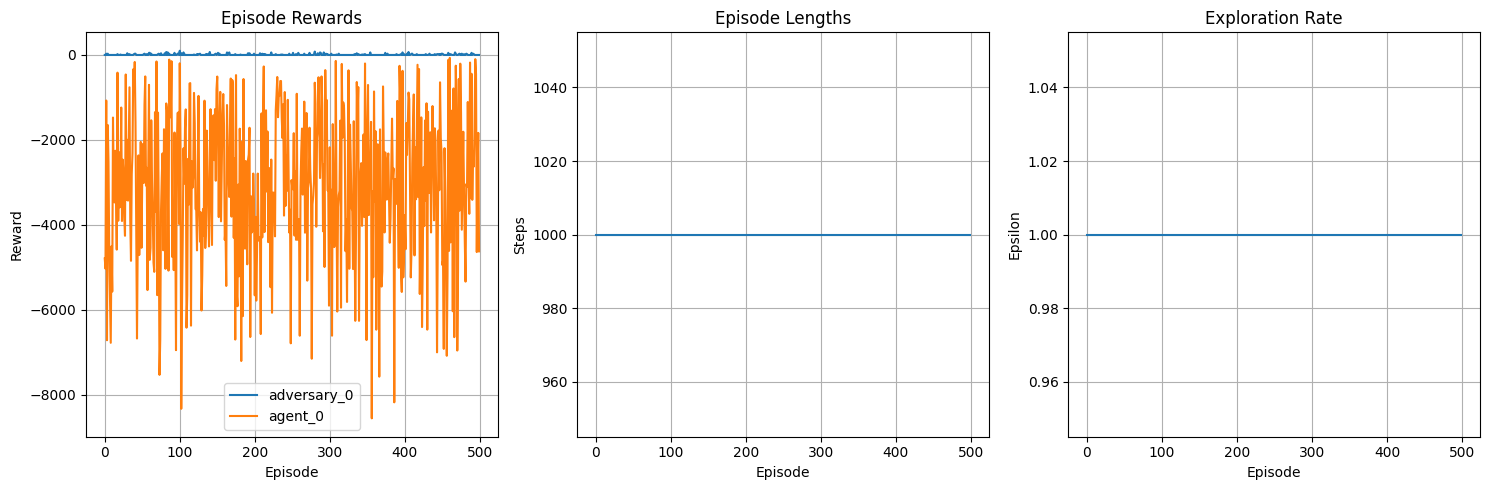

In [5]:
# %% step 5
def plot_training_results(rewards, lengths, exploration):
    """Plot training metrics"""
    plt.figure(figsize=(15, 5))
    
    # Rewards
    plt.subplot(1, 3, 1)
    for agent, agent_rewards in rewards.items():
        plt.plot(agent_rewards, label=agent)
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid()
    
    # Episode lengths
    plt.subplot(1, 3, 2)
    plt.plot(lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.grid()
    
    # Exploration
    plt.subplot(1, 3, 3)
    plt.plot(exploration)
    plt.title("Exploration Rate")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.grid()
    
    plt.tight_layout()
    plt.show()

plot_training_results(rewards, lengths, exploration)

In [6]:
# %%step 6
def evaluate_agents(env, agents, num_episodes=10):
    """Evaluate trained agents"""
    total_rewards = {agent: 0 for agent in agents.keys()}
    
    for _ in range(num_episodes):
        env.reset()
        episode_rewards = {agent: 0 for agent in agents.keys()}
        
        for agent in env.agent_iter():
            observation, reward, termination, truncation, _ = env.last()
            done = termination or truncation
            
            # Get action from agent (None if agent is dead)
            action = agents[agent].act(observation, training=False) if not done else None
            
            # Step the environment
            env.step(action)
            
            # Store reward
            if not done:
                episode_rewards[agent] += reward
            
            if all(env.terminations.values()) or all(env.truncations.values()):
                break
        
        for agent in agents.keys():
            total_rewards[agent] += episode_rewards[agent]
    
    # Calculate average rewards
    avg_rewards = {agent: total_rewards[agent]/num_episodes for agent in agents.keys()}
    return avg_rewards

# Evaluate
avg_rewards = evaluate_agents(env, trained_agents)
print("Average evaluation rewards:", avg_rewards)

Average evaluation rewards: {'adversary_0': 0.0, 'agent_0': -149.86590870855716}


In [7]:
# %%step 7
def watch_episode(env, agents):
    """Run and render one episode"""
    env.reset()
    
    for agent in env.agent_iter():
        observation, reward, termination, truncation, _ = env.last()
        done = termination or truncation
        
        # Get action from agent (None if agent is dead)
        action = agents[agent].act(observation, training=False) if not done else None
        
        # Step the environment
        env.step(action)
        
        # Render
        env.render()
        
        if all(env.terminations.values()) or all(env.truncations.values()):
            break
    
    env.close()

# Watch trained agents
print("Running demonstration episode...")
watch_episode(env, trained_agents)
print("Demonstration completed!")

Running demonstration episode...
Demonstration completed!
